In [ ]:
# 1. Install Kaggle API
!pip install kaggle


In [ ]:
# 2. Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wendyawuor","key":"28895fa00a546aba1dece85694f80e13"}'}

In [ ]:
# 3. Move key to correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 4. Download dataset
!kaggle datasets download -d robinreni/revitsone-5class


Dataset URL: https://www.kaggle.com/datasets/robinreni/revitsone-5class
License(s): DbCL-1.0
 97% 951M/983M [00:16<00:00, 61.6MB/s]
100% 983M/983M [00:16<00:00, 61.5MB/s]


In [ ]:
#5: Unzip dataset
!unzip -q revitsone-5class.zip

In [ ]:
# 6.Import Libraries
import os
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2

In [ ]:
#7.Setting Paths
original_dir = "revitsone-5classes/Revitsone-5classes"
base_dir = "dataset_split"

In [ ]:
#8.Create folders for train, val, test
for split in ['train', 'val', 'test']:
    for cls in os.listdir(original_dir):
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)


In [ ]:
#9.Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [ ]:
#10.Split the class folders into train and test
for cls in os.listdir(original_dir):
    cls_path = os.path.join(original_dir, cls)
    images = os.listdir(cls_path)
    np.random.shuffle(images)

    train_end = int(len(images) * train_ratio)
    val_end = int(len(images) * (train_ratio + val_ratio))

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(base_dir, 'train', cls))
    for f in val_files:
      shutil.copy(os.path.join(cls_path, f), os.path.join(base_dir, 'val', cls))
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(base_dir, 'test', cls))

print("✅ Dataset split done!")

✅ Dataset split done!


In [ ]:
#11.Setting up data generators
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
test_data_gen=ImageDataGenerator(
    rescale=1./255
)
val_data_gen=ImageDataGenerator(
    rescale=1./255
)

In [ ]:
#12.Generating Images
train_data = train_data_gen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_data_gen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_data = test_data_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7535 images belonging to 5 classes.
Found 1613 images belonging to 5 classes.
Found 1618 images belonging to 5 classes.


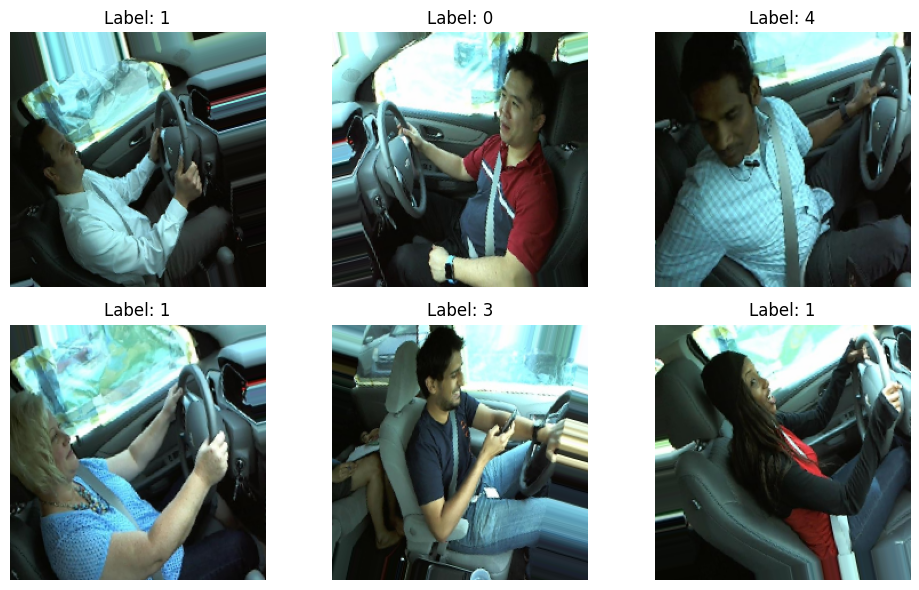

In [ ]:
#14.Get one batch of augmented images
images, labels = next(train_data)
#15.Plot first 6 images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].argmax()}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#16.Creating the model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # ✅ 5 classes
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # because your labels are one-hot
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#17.Early stopping
callback =[
    EarlyStopping(monitor = 'val_loss', patience = 3),
    ModelCheckpoint('best_model.h5',save_best_only=True)
]

In [ ]:
#18.Finding Corrupted/invalid images
from PIL import Image
import os

def find_corrupted_images(directory):
    corrupted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            try:
                img = Image.open(filepath)
                img.verify()  # Verify that the file is an image
            except (IOError, SyntaxError) as e:
                print(f"Corrupted or invalid image file: {filepath} - {e}")
                corrupted_files.append(filepath)
            except Exception as e:
                print(f"Error processing file: {filepath} - {e}")
                corrupted_files.append(filepath)
    return corrupted_files

print("Checking for corrupted images in the dataset split:")
corrupted_train = find_corrupted_images(os.path.join(base_dir, 'train'))
corrupted_val = find_corrupted_images(os.path.join(base_dir, 'val'))
corrupted_test = find_corrupted_images(os.path.join(base_dir, 'test'))

if not corrupted_train and not corrupted_val and not corrupted_test:
    print("No corrupted or invalid image files found.")

Checking for corrupted images in the dataset split:
Corrupted or invalid image file: dataset_split/train/turning/img_62337.jpg - cannot identify image file 'dataset_split/train/turning/img_62337.jpg'
Corrupted or invalid image file: dataset_split/train/turning/img_84605.jpg - cannot identify image file 'dataset_split/train/turning/img_84605.jpg'
Corrupted or invalid image file: dataset_split/train/turning/img_70552.jpg - cannot identify image file 'dataset_split/train/turning/img_70552.jpg'
Corrupted or invalid image file: dataset_split/train/turning/img_101434.jpg - cannot identify image file 'dataset_split/train/turning/img_101434.jpg'
Corrupted or invalid image file: dataset_split/train/other_activities/img_22266.jpg - cannot identify image file 'dataset_split/train/other_activities/img_22266.jpg'
Corrupted or invalid image file: dataset_split/train/other_activities/img_4664.jpg - cannot identify image file 'dataset_split/train/other_activities/img_4664.jpg'
Corrupted or invalid ima

In [ ]:
#19.Remove corrupted images
all_corrupted_files = corrupted_train + corrupted_val + corrupted_test
for f in all_corrupted_files:
    if os.path.exists(f):
        os.remove(f)
        print(f"Removed corrupted file: {f}")

Removed corrupted file: dataset_split/train/turning/img_62337.jpg
Removed corrupted file: dataset_split/train/turning/img_84605.jpg
Removed corrupted file: dataset_split/train/turning/img_70552.jpg
Removed corrupted file: dataset_split/train/turning/img_101434.jpg
Removed corrupted file: dataset_split/train/other_activities/img_22266.jpg
Removed corrupted file: dataset_split/train/other_activities/img_4664.jpg
Removed corrupted file: dataset_split/train/other_activities/img_13541.jpg
Removed corrupted file: dataset_split/train/other_activities/img_13396.jpg
Removed corrupted file: dataset_split/train/other_activities/img_7973.jpg
Removed corrupted file: dataset_split/train/other_activities/img_13318.jpg
Removed corrupted file: dataset_split/train/other_activities/img_13625.jpg
Removed corrupted file: dataset_split/val/turning/img_67523.jpg
Removed corrupted file: dataset_split/val/other_activities/img_20398.jpg
Removed corrupted file: dataset_split/val/other_activities/img_79.jpg
Remov

In [ ]:
#20.Regenerate data generators
train_data = train_data_gen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_data_gen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_data = test_data_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7524 images belonging to 5 classes.
Found 1610 images belonging to 5 classes.
Found 1617 images belonging to 5 classes.


In [ ]:
#21.Fit the model
history = model.fit(train_data,validation_data=val_data, epochs=10,callbacks=callback)

loss,accuracy=model.evaluate(test_data)
print(f'test loss:{loss}')
print(f'accuracy is:{accuracy}')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.2154 - loss: 1.7753

236/236 ━━━━━━━━━━━━━━━━━━━━ 114s 452ms/step - accuracy: 0.2155 - loss: 1.7747 - val_accuracy: 0.3112 - val_loss: 1.6145
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.3379 - loss: 1.4929

236/236 ━━━━━━━━━━━━━━━━━━━━ 104s 441ms/step - accuracy: 0.3380 - loss: 1.4927 - val_accuracy: 0.5037 - val_loss: 1.2340
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4211 - loss: 1.3523

236/236 ━━━━━━━━━━━━━━━━━━━━ 102s 431ms/step - accuracy: 0.4212 - loss: 1.3522 - val_accuracy: 0.5292 - val_loss: 1.0803
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.4991 - loss: 1.2189

236/236 ━━━━━━━━━━━━━━━━━━━━ 142s 429ms/step - accuracy: 0.4991 - loss: 1.2189 - val_accuracy: 0.6186 - val_loss: 0.9518
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.5490 - loss: 1.1046

236/236 ━━━━━━━━━━━━━━━━━━━━ 142s 430ms/step - accuracy: 0.5491 - loss: 1.1044 - val_accuracy: 0.7118 - val_loss: 0.7629
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6110 - loss: 0.9813

236/236 ━━━━━━━━━━━━━━━━━━━━ 102s 431ms/step - accuracy: 0.6111 - loss: 0.9811 - val_accuracy: 0.7242 - val_loss: 0.6930
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6435 - loss: 0.9157

236/236 ━━━━━━━━━━━━━━━━━━━━ 103s 438ms/step - accuracy: 0.6435 - loss: 0.9155 - val_accuracy: 0.7671 - val_loss: 0.5888
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 104s 439ms/step - accuracy: 0.6912 - loss: 0.8094 - val_accuracy: 0.7783 - val_loss: 0.5962
Epoch 9/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.7341 - loss: 0.7153

236/236 ━━━━━━━━━━━━━━━━━━━━ 102s 433ms/step - accuracy: 0.7341 - loss: 0.7153 - val_accuracy: 0.8137 - val_loss: 0.4799
Epoch 10/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7388 - loss: 0.6750

236/236 ━━━━━━━━━━━━━━━━━━━━ 102s 432ms/step - accuracy: 0.7388 - loss: 0.6750 - val_accuracy: 0.8348 - val_loss: 0.4085
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.8368 - loss: 0.4423
test loss:0.44913509488105774
accuracy is:0.8342610001564026


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

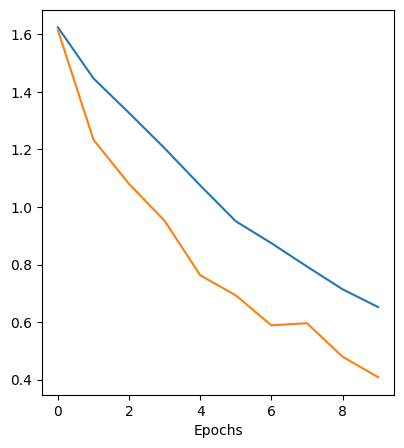

In [ ]:
#22.Plotting training and validation loss & accuracy
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt

In [ ]:
#23.Making prediction model
predictions = model.predict(test_data)

y_pred = np.argmax(predictions, axis = 1)
y_test= np.argmax(test_data, axis = 1)


classification_report(y_pred, y_test)

cm = pd.DataFrame(confusion_matrix(y_pred,y_test), columns = ['Normal', 'Pneumonia'], index =['Normal', 'Pneumonia'])


51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step
